In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_recall_curve, auc, precision_score, recall_score
import numpy as np
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

# Setup

In [2]:
df = pd.read_csv("data/results/time_data.csv", sep=";")
df["time"] = pd.to_datetime(df["time"])

C:\Users\Jefferson\AppData\Local\Temp\ipykernel_15912\3960761302.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["time"] = pd.to_datetime(df["time"])


In [3]:
class FloodDataset(Dataset):
    def __init__(self, data, sequence_length, predict_ahead):
        self.data = data
        self.sequence_length = sequence_length
        self.predict_ahead = predict_ahead

    def __len__(self):
        # Ensure length is non-negative
        return max(0, len(self.data) - self.sequence_length - self.predict_ahead + 1)

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self):
            raise IndexError(f"Index {idx} is out of bounds for dataset of size {len(self)}")
        
        # Input sequence: rain_gauge_1 and rain_gauge_2 for the past `sequence_length` time steps
        x = self.data[idx:idx+self.sequence_length, :-1]
        
        y = self.data[idx+self.sequence_length + self.predict_ahead - 1, -1]
        
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        
        return x, y

In [4]:
class FloodLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(FloodLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [5]:
def collate_fn(batch):
    # Separate inputs and labels
    inputs, labels = zip(*batch)
    
    # Pad the input sequences to the same length
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    
    # Stack the labels into a single tensor
    labels = torch.stack(labels)
    
    return inputs_padded, labels

In [6]:
def print_class_distribution(data, dataset_name):
    class_counts = np.unique(data[:, -1], return_counts=True)
    print(f"Class distribution in {dataset_name}:")
    for class_label, count in zip(class_counts[0], class_counts[1]):
        print(f"Class {int(class_label)}: {count} examples")

In [7]:
def evalute_model(model, dataloader, title="Matriz de confusão"):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.squeeze().cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Flood", "Flood"], yticklabels=["No Flood", "Flood"])
    plt.xlabel("Valor Predito")
    plt.ylabel("Real")
    plt.title(title)
    plt.show()

    class_report = classification_report(all_labels, all_predictions, target_names=["No Flood", "Flood"])
    print("\nClassification Report:\n", class_report)

In [8]:
def train_lstm(train_dataloader, hidden_size, num_layers, criterion=nn.BCELoss(), has_tweets=False):
    input_size = 2  # rain_gauge_1 and rain_gauge_2
    output_size = 1  # flood_boolean (binary)

    if has_tweets:
        input_size += 1

    model = FloodLSTM(input_size, hidden_size, num_layers, output_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50
    for _ in range(num_epochs):
        model.train()
        for inputs, labels in train_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model

In [9]:
def plot_f1_score(model_list, model_names, dataloader, title="Comparação de F1-Score entre Modelos"):
    """Plota o gráfico do F1-Score para comparar modelos."""
    f1_scores = []

    for model in model_list:
        model.eval()
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for inputs, labels in dataloader:
                outputs = model(inputs)
                predicted = (outputs > 0.5).float()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.squeeze().cpu().numpy())

        # Calcular F1-Score
        f1 = f1_score(all_labels, all_predictions)
        f1_scores.append(f1)

    # Plotar F1-Score
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, f1_scores, color='skyblue')
    plt.xlabel('Modelos')
    plt.ylabel('F1-Score')
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [10]:
def plot_auc_pr(model_list, model_names, dataloader, title="Comparação de AUC-PR entre Modelos"):
    """Plota o gráfico do AUC-PR para comparar modelos."""
    plt.figure(figsize=(10, 6))

    for model, name in zip(model_list, model_names):
        model.eval()
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for inputs, labels in dataloader:
                outputs = model(inputs)
                probs = torch.sigmoid(outputs).cpu().numpy()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(probs.squeeze())

        # Calcular Precision-Recall e AUC-PR
        precision, recall, _ = precision_recall_curve(all_labels, all_predictions)
        auc_pr = auc(recall, precision)
        
        # Plotar a curva Precision-Recall
        plt.plot(recall, precision, label=f"{name} (AUC-PR = {auc_pr:.2f})")
    
    # Configurações do gráfico
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

In [11]:
def plot_precision_recall(models, model_names, dataloader, title="Precisão e Recall dos Modelos"):
    precisions = []
    recalls = []

    for model in models:
        model.eval()
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for inputs, labels in dataloader:
                outputs = model(inputs)
                predicted = (outputs > 0.5).float()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.squeeze().cpu().numpy())
        
        # Calcular Precisão e Recall
        precision = precision_score(all_labels, all_predictions, zero_division=0)
        recall = recall_score(all_labels, all_predictions, zero_division=0)

        precisions.append(precision)
        recalls.append(recall)

    # Criar os gráficos
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Gráfico da Precisão
    axes[0].bar(model_names, precisions, color='blue', alpha=0.7)
    axes[0].set_title("Precisão")
    axes[0].set_ylabel("Precisão")
    axes[0].set_ylim([0, 1])

    # Gráfico do Recall
    axes[1].bar(model_names, recalls, color='green', alpha=0.7)
    axes[1].set_title("Recall")
    axes[1].set_ylabel("Recall")
    axes[1].set_ylim([0, 1])

    # Título geral do gráfico
    plt.suptitle(title)
    plt.show()

In [107]:
def plot_confusion_matrices_from_models(models, dataloader, model_names, title="Comparação de Matrizes de Confusão"):
    if len(models) != 3 or len(model_names) != 3:
        raise ValueError("Forneça exatamente três modelos e três nomes de modelos.")
    
    conf_matrices = []

    # Avaliação para cada modelo
    for model in models:
        model.eval()
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for inputs, labels in dataloader:
                outputs = model(inputs)
                predicted = (outputs > 0.5).float()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.squeeze().cpu().numpy())
        
        # Matriz de confusão para o modelo atual
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        conf_matrices.append(conf_matrix)

    # Plotagem das matrizes de confusão
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(title, fontsize=20)
    
    for i, (conf_matrix, model_name) in enumerate(zip(conf_matrices, model_names)):
        ax = axes[i]
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_title(model_name)
        ax.set_xlabel('Predito')
        ax.set_ylabel('Real')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [12]:
MODEL_DIR_PATH = "models/lstm"

In [13]:
data = df[["812A", "833A", "flood"]].values

sequence_length = 6
predict_ahead = 1

train_size = int(len(data) * 0.70)
train_data = data[:train_size]
test_data = data[train_size:]

print_class_distribution(train_data, "training data")

Class distribution in training data:
Class 0: 8656 examples
Class 1: 416 examples


In [14]:
test_dataset = FloodDataset(test_data, sequence_length, predict_ahead)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [15]:
data_with_tweets = df[["812A", "833A", "tweets", "flood"]].values

train_size = int(len(data_with_tweets) * 0.70)
train_data_t = data_with_tweets[:train_size]
test_data_t = data_with_tweets[train_size:]

In [16]:
test_dataset_with_tweets = FloodDataset(test_data_t, sequence_length, predict_ahead)
test_dataloader_with_tweets = DataLoader(test_dataset_with_tweets, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [70]:
NEURONS = 32
LAYERS = 1

In [18]:
train_dataset = FloodDataset(train_data, sequence_length, predict_ahead)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Séries de precipitação - Teste de parâmetros

## Camadas: 1

### Neurônios: 32

In [19]:
model = train_lstm(train_dataloader, 32, 1)

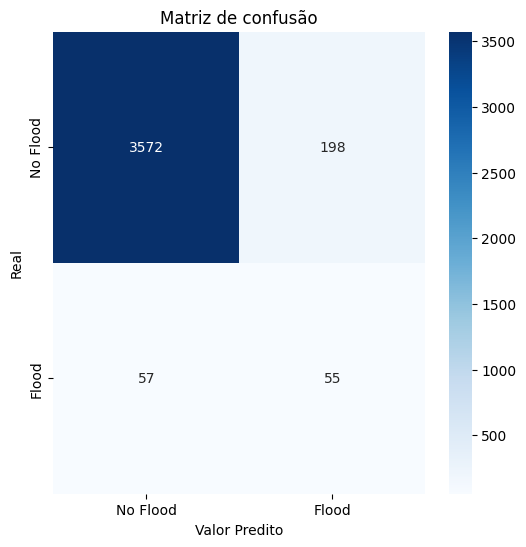


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.98      0.95      0.97      3770
       Flood       0.22      0.49      0.30       112

    accuracy                           0.93      3882
   macro avg       0.60      0.72      0.63      3882
weighted avg       0.96      0.93      0.95      3882



In [20]:
report = evalute_model(model, test_dataloader)

In [21]:
torch.save(model.state_dict(), "models/lstm/lstm_unbalaced_1_32")

### Neurônios: 64

In [22]:
model = train_lstm(train_dataloader, 64, 1)

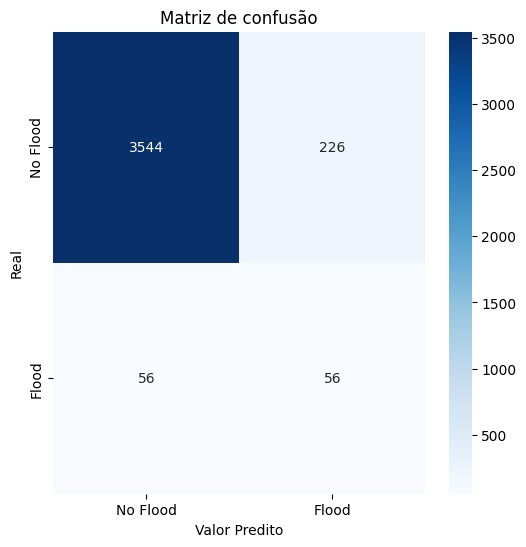


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.98      0.94      0.96      3770
       Flood       0.20      0.50      0.28       112

    accuracy                           0.93      3882
   macro avg       0.59      0.72      0.62      3882
weighted avg       0.96      0.93      0.94      3882



In [23]:
report = evalute_model(model, test_dataloader)

In [24]:
torch.save(model.state_dict(), "models/lstm/lstm_unbalaced_1_64")

### Neurônios: 128

In [25]:
model = train_lstm(train_dataloader, 128, 1)

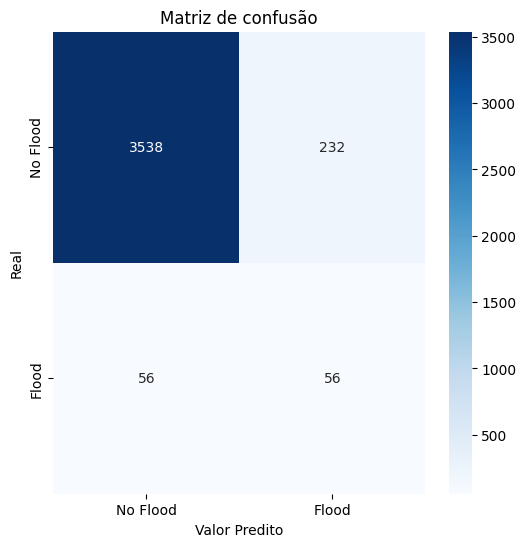


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.98      0.94      0.96      3770
       Flood       0.19      0.50      0.28       112

    accuracy                           0.93      3882
   macro avg       0.59      0.72      0.62      3882
weighted avg       0.96      0.93      0.94      3882



In [26]:
report = evalute_model(model, test_dataloader)

In [27]:
torch.save(model.state_dict(), "models/lstm/lstm_unbalaced_1_128")

## Camadas: 2

### Neurônios: 32

In [28]:
model = train_lstm(train_dataloader, 32, 2)

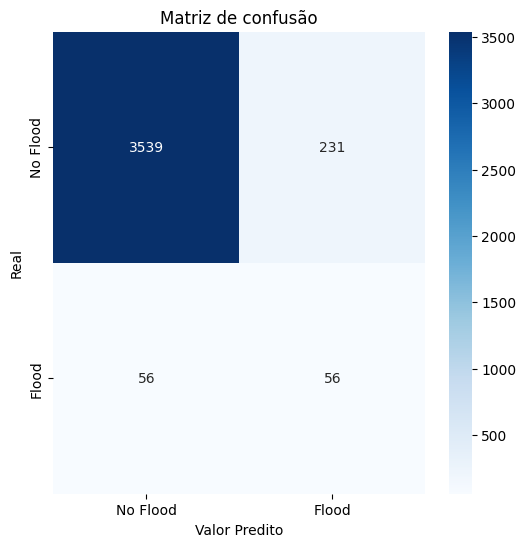


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.98      0.94      0.96      3770
       Flood       0.20      0.50      0.28       112

    accuracy                           0.93      3882
   macro avg       0.59      0.72      0.62      3882
weighted avg       0.96      0.93      0.94      3882



In [29]:
report = evalute_model(model, test_dataloader)

In [30]:
torch.save(model.state_dict(), "models/lstm/lstm_unbalaced_2_32")

### Neurônios: 64

In [31]:
model = train_lstm(train_dataloader, 64, 2)

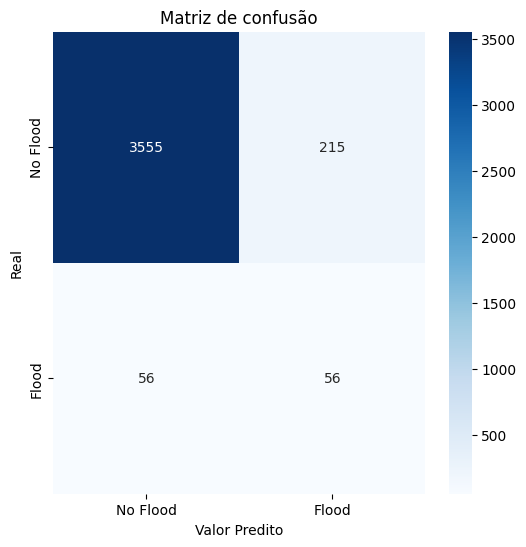


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.98      0.94      0.96      3770
       Flood       0.21      0.50      0.29       112

    accuracy                           0.93      3882
   macro avg       0.60      0.72      0.63      3882
weighted avg       0.96      0.93      0.94      3882



In [32]:
report = evalute_model(model, test_dataloader)

In [33]:
torch.save(model.state_dict(), "models/lstm/lstm_unbalaced_2_64")

### Neurônios: 128

In [34]:
model = train_lstm(train_dataloader, 128, 2)

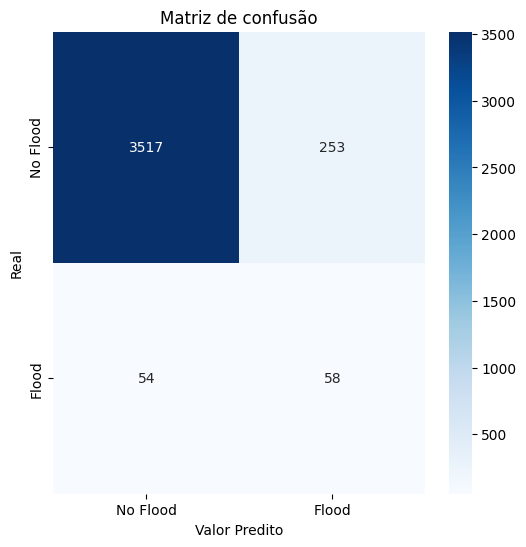


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.98      0.93      0.96      3770
       Flood       0.19      0.52      0.27       112

    accuracy                           0.92      3882
   macro avg       0.59      0.73      0.62      3882
weighted avg       0.96      0.92      0.94      3882



In [35]:
report = evalute_model(model, test_dataloader)

In [36]:
torch.save(model.state_dict(), "models/lstm/lstm_unbalaced_2_128")

## Comparação de modelos

In [37]:
lstm_1_32 = FloodLSTM(2, 32, 1, 1)
lstm_1_32.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_unbalaced_1_32", weights_only=True))

lstm_1_64 = FloodLSTM(2, 64, 1, 1)
lstm_1_64.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_unbalaced_1_64", weights_only=True))

lstm_1_128 = FloodLSTM(2, 128, 1, 1)
lstm_1_128.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_unbalaced_1_128", weights_only=True))

lstm_2_32 = FloodLSTM(2, 32, 2, 1)
lstm_2_32.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_unbalaced_2_32", weights_only=True))

lstm_2_64 = FloodLSTM(2, 64, 2, 1)
lstm_2_64.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_unbalaced_2_64", weights_only=True))

lstm_2_128 = FloodLSTM(2, 128, 2, 1)
lstm_2_128.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_unbalaced_2_128", weights_only=True))

<All keys matched successfully>

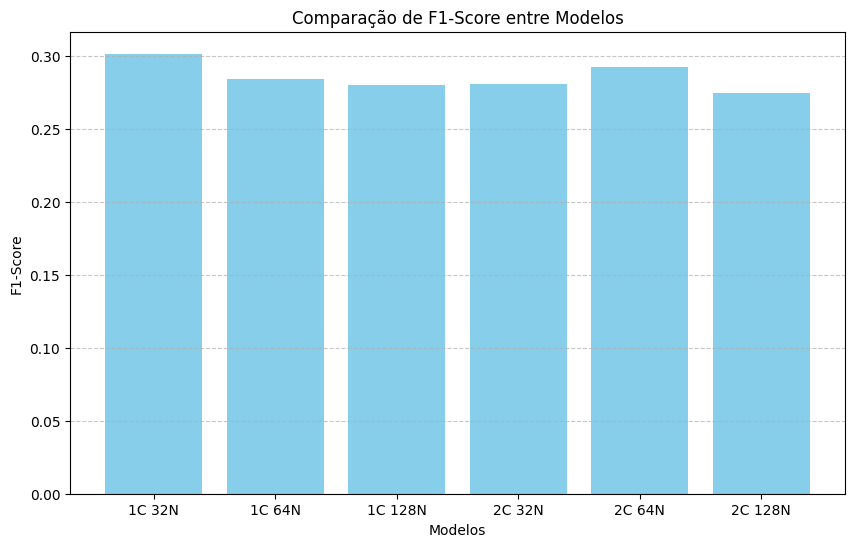

In [38]:
plot_f1_score([lstm_1_32, lstm_1_64, lstm_1_128, lstm_2_32, lstm_2_64, lstm_2_128], ["1C 32N", "1C 64N", "1C 128N", "2C 32N", "2C 64N", "2C 128N"], test_dataloader)

# Séries de precipitação

## Oversample

In [74]:
def oversample_minority_class_smote(data):
    X = data[:, :-1]
    y = data[:, -1]

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    balanced_data = np.hstack([X_resampled, y_resampled.reshape(-1, 1)])

    return balanced_data

In [75]:
train_data_oversampled = oversample_minority_class_smote(train_data)

print_class_distribution(train_data_oversampled, "oversampled training data")

Class distribution in oversampled training data:
Class 0: 8656 examples
Class 1: 8656 examples


In [76]:
train_dataset_oversampled = FloodDataset(train_data_oversampled, sequence_length, predict_ahead)
train_dataloader_oversampled = DataLoader(train_dataset_oversampled, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [77]:
oversampled_model = train_lstm(train_dataloader_oversampled, NEURONS, LAYERS)

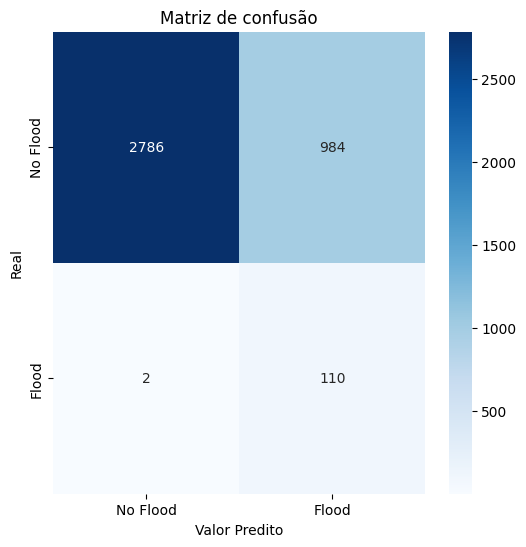


Classification Report:
               precision    recall  f1-score   support

    No Flood       1.00      0.74      0.85      3770
       Flood       0.10      0.98      0.18       112

    accuracy                           0.75      3882
   macro avg       0.55      0.86      0.52      3882
weighted avg       0.97      0.75      0.83      3882



In [78]:
report = evalute_model(oversampled_model, test_dataloader)

In [79]:
torch.save(oversampled_model.state_dict(), "models/lstm/lstm_oversampled")

## Treinamento com pesos nas classes

In [80]:
train_df = df[:train_size]

num_negatives = len(train_df[train_df["flood"] == 0])
num_positives = len(train_df[train_df["flood"] == 1])

pos_weight = torch.tensor([num_negatives/num_positives])
weighted_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [81]:
weighted_model = train_lstm(train_dataloader, NEURONS, LAYERS, criterion=weighted_criterion)

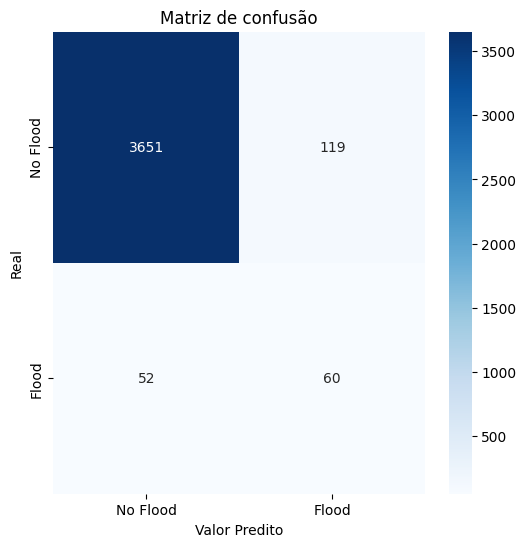


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.97      0.98      3770
       Flood       0.34      0.54      0.41       112

    accuracy                           0.96      3882
   macro avg       0.66      0.75      0.69      3882
weighted avg       0.97      0.96      0.96      3882



In [82]:
report = evalute_model(weighted_model, test_dataloader)

In [83]:
torch.save(weighted_model.state_dict(), "models/lstm/lstm_weighted")

# Treinamento com tweets

## Dados desbalanceados

In [84]:
train_dataset_with_tweets = FloodDataset(train_data_t, sequence_length, predict_ahead)
train_dataloader_with_tweets = DataLoader(train_dataset_with_tweets, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [85]:
unbalaced_model_t = train_lstm(train_dataloader_with_tweets, NEURONS, LAYERS, has_tweets=True)

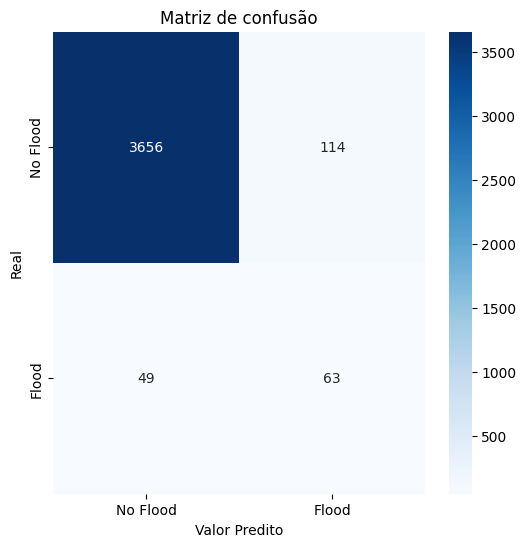


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.97      0.98      3770
       Flood       0.36      0.56      0.44       112

    accuracy                           0.96      3882
   macro avg       0.67      0.77      0.71      3882
weighted avg       0.97      0.96      0.96      3882



In [86]:
report = evalute_model(unbalaced_model_t, test_dataloader_with_tweets)

In [87]:
torch.save(unbalaced_model_t.state_dict(), "models/lstm/lstm_unbalaced_with_tweets")

## Oversample

In [88]:
train_data_oversampled_t = oversample_minority_class_smote(train_data_t)

print_class_distribution(train_data_oversampled_t, "oversampled training data")

Class distribution in oversampled training data:
Class 0: 8656 examples
Class 1: 8656 examples


In [89]:
train_dataset_oversampled_t = FloodDataset(train_data_oversampled_t, sequence_length, predict_ahead)
train_dataloader_oversampled_t = DataLoader(train_dataset_oversampled_t, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [90]:
oversampled_model_t = train_lstm(train_dataloader_oversampled_t, NEURONS, LAYERS, has_tweets=True)

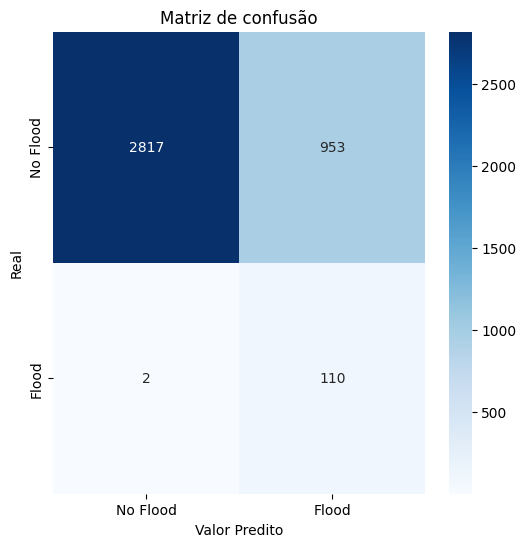


Classification Report:
               precision    recall  f1-score   support

    No Flood       1.00      0.75      0.86      3770
       Flood       0.10      0.98      0.19       112

    accuracy                           0.75      3882
   macro avg       0.55      0.86      0.52      3882
weighted avg       0.97      0.75      0.84      3882



In [91]:
report = evalute_model(oversampled_model_t, test_dataloader_with_tweets)

In [92]:
torch.save(oversampled_model_t.state_dict(), "models/lstm/lstm_oversampled_with_tweets")

## Peso nas classes

In [93]:
train_df = df[:train_size]

num_negatives = len(train_df[train_df["flood"] == 0])
num_positives = len(train_df[train_df["flood"] == 1])

pos_weight = torch.tensor([num_negatives/num_positives])
weighted_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [94]:
weighted_model_t = train_lstm(train_dataloader_with_tweets, NEURONS, LAYERS, criterion=weighted_criterion, has_tweets=True)

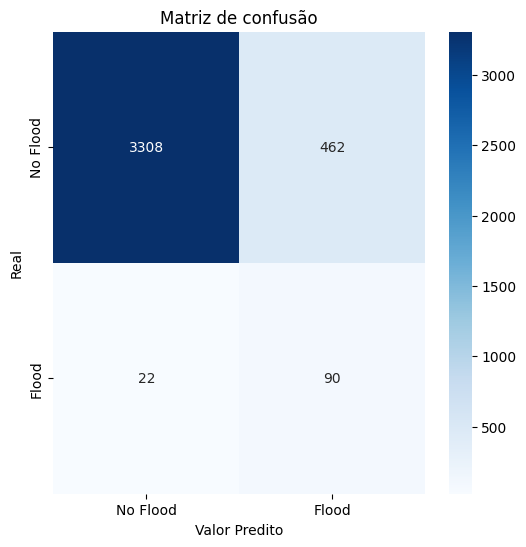


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.88      0.93      3770
       Flood       0.16      0.80      0.27       112

    accuracy                           0.88      3882
   macro avg       0.58      0.84      0.60      3882
weighted avg       0.97      0.88      0.91      3882



In [95]:
report = evalute_model(weighted_model_t, test_dataloader_with_tweets)

In [96]:
torch.save(weighted_model_t.state_dict(), "models/lstm/lstm_weighted_with_tweets")

# Comparações

## Parametros diferentes

In [109]:
unbalaced_model_1_32 = FloodLSTM(2, 32, 1, 1)
unbalaced_model_1_32.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_unbalaced_1_32", weights_only=True))

unbalaced_model_1_64 = FloodLSTM(2, 64, 1, 1)
unbalaced_model_1_64.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_unbalaced_1_64", weights_only=True))

unbalaced_model_1_128 = FloodLSTM(2, 128, 1, 1)
unbalaced_model_1_128.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_unbalaced_1_128", weights_only=True))

<All keys matched successfully>

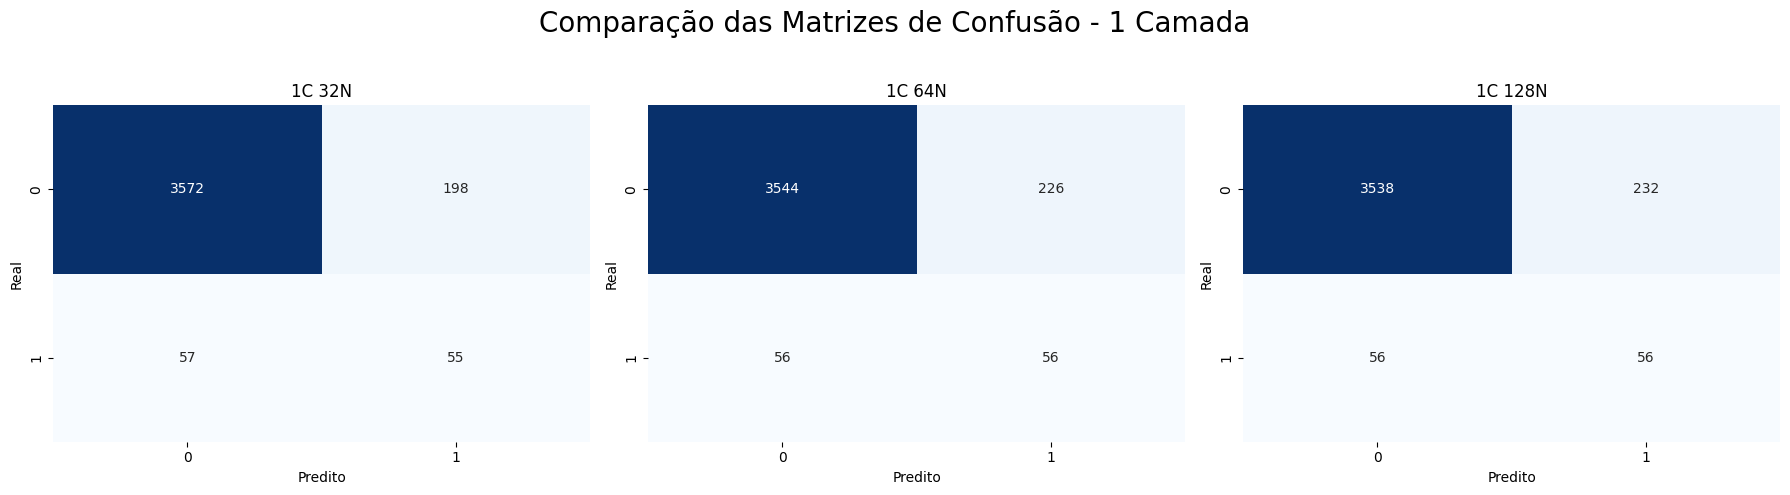

In [112]:
plot_confusion_matrices_from_models(
    models=[unbalaced_model_1_32, unbalaced_model_1_64, unbalaced_model_1_128],
    dataloader=test_dataloader,
    model_names=["1C 32N", "1C 64N", "1C 128N"],
    title="Comparação das Matrizes de Confusão - 1 Camada"
)

In [113]:
unbalaced_model_2_32 = FloodLSTM(2, 32, 2, 1)
unbalaced_model_2_32.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_unbalaced_2_32", weights_only=True))

unbalaced_model_2_64 = FloodLSTM(2, 64, 2, 1)
unbalaced_model_2_64.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_unbalaced_2_64", weights_only=True))

unbalaced_model_2_128 = FloodLSTM(2, 128, 2, 1)
unbalaced_model_2_128.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_unbalaced_2_128", weights_only=True))

<All keys matched successfully>

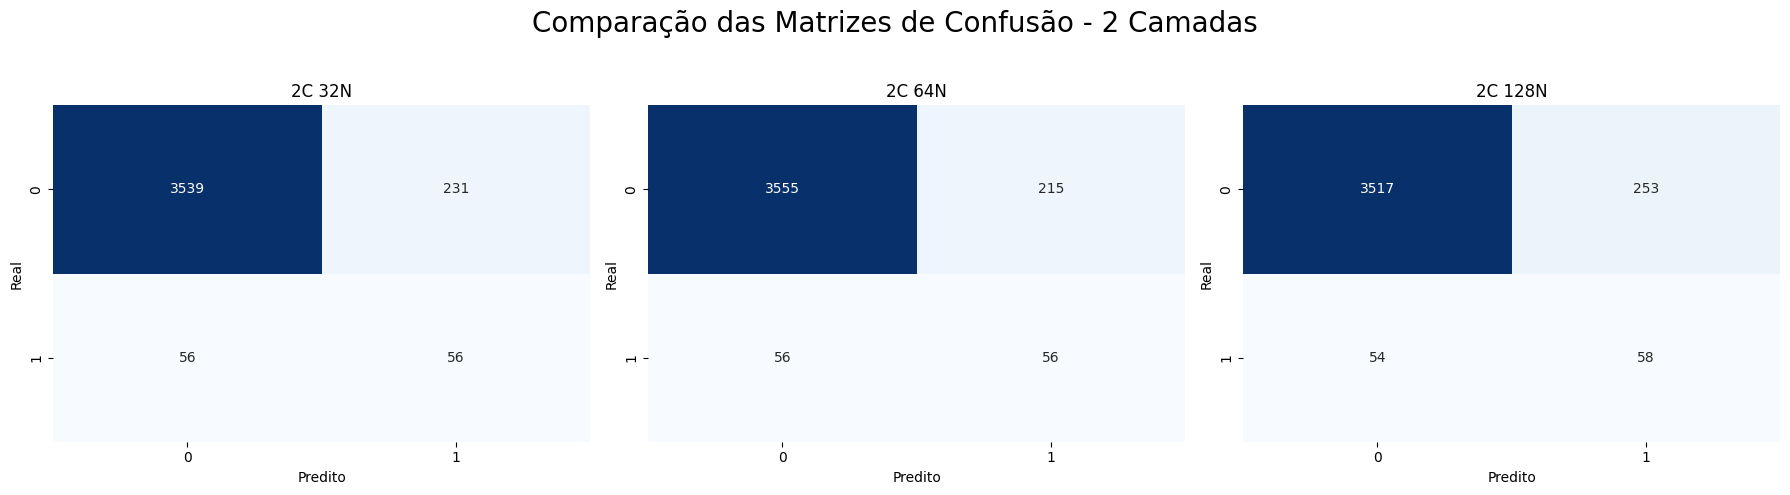

In [114]:
plot_confusion_matrices_from_models(
    models=[unbalaced_model_2_32, unbalaced_model_2_64, unbalaced_model_2_128],
    dataloader=test_dataloader,
    model_names=["2C 32N", "2C 64N", "2C 128N"],
    title="Comparação das Matrizes de Confusão - 2 Camadas"
)

## Séries de precipitação 

In [99]:
unbalaced_model = FloodLSTM(2, NEURONS, LAYERS, 1)
unbalaced_model.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_unbalaced_{LAYERS}_{NEURONS}", weights_only=True))

oversampled_model = FloodLSTM(2, NEURONS, LAYERS, 1)
oversampled_model.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_oversampled", weights_only=True))

weighted_model = FloodLSTM(2, NEURONS, LAYERS, 1)
weighted_model.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_weighted", weights_only=True))

<All keys matched successfully>

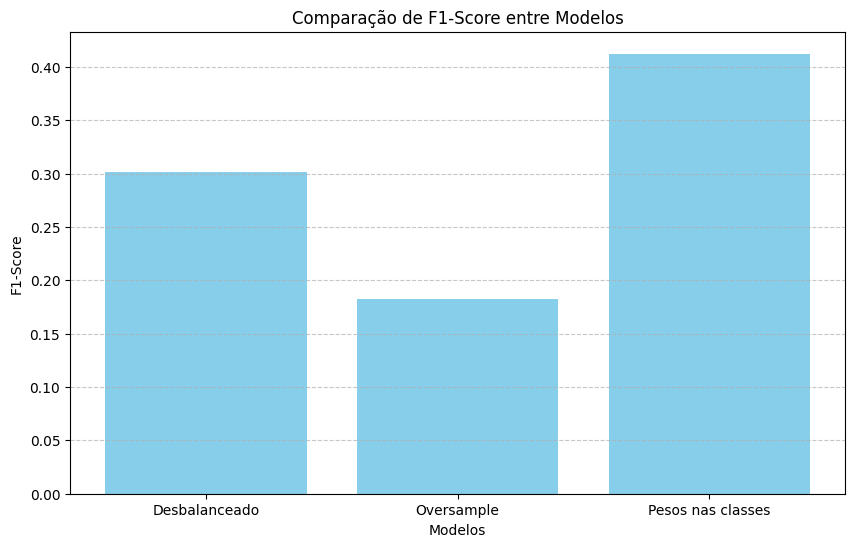

In [ ]:
plot_f1_score([unbalaced_model, oversampled_model, weighted_model], ["Desbalanceado", "Oversample", "Pesos nas classes"], test_dataloader)

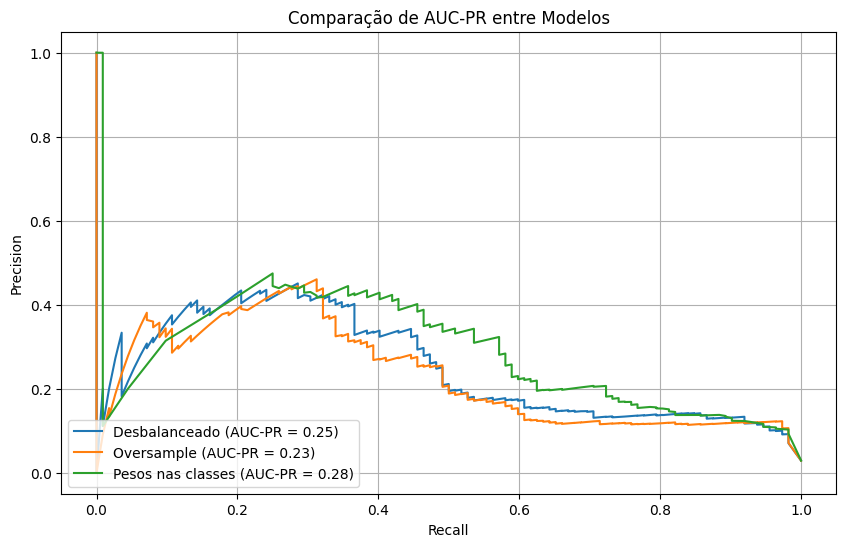

In [101]:
plot_auc_pr([unbalaced_model, oversampled_model, weighted_model], ["Desbalanceado", "Oversample", "Pesos nas classes"], test_dataloader)

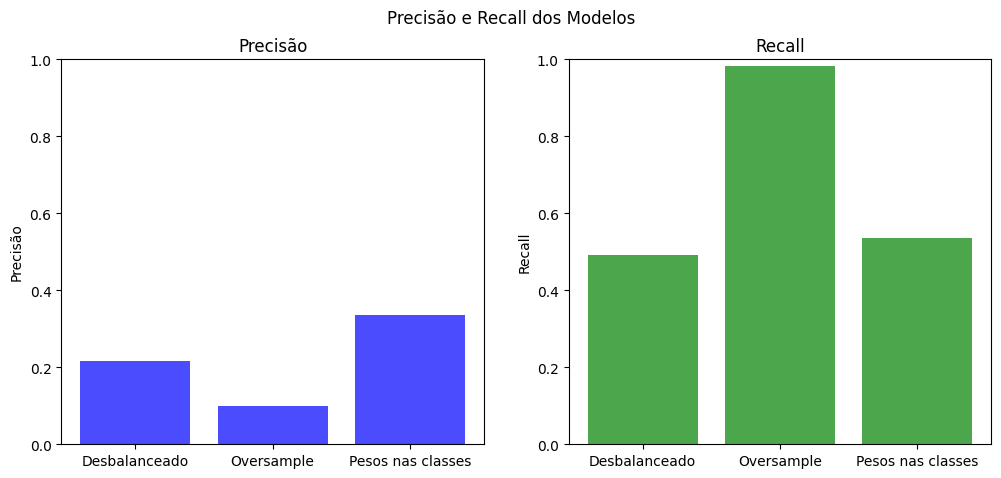

In [102]:
plot_precision_recall([unbalaced_model, oversampled_model, weighted_model], ["Desbalanceado", "Oversample", "Pesos nas classes"], test_dataloader)

## Séries de precipitação com tweets

In [103]:
unbalaced_model_t = FloodLSTM(3, NEURONS, LAYERS, 1)
unbalaced_model_t.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_unbalaced_with_tweets", weights_only=True))

oversampled_model_t = FloodLSTM(3, NEURONS, LAYERS, 1)
oversampled_model_t.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_oversampled_with_tweets", weights_only=True))

weighted_model_t = FloodLSTM(3, NEURONS, LAYERS, 1)
weighted_model_t.load_state_dict(torch.load(f"{MODEL_DIR_PATH}/lstm_weighted_with_tweets", weights_only=True))

<All keys matched successfully>

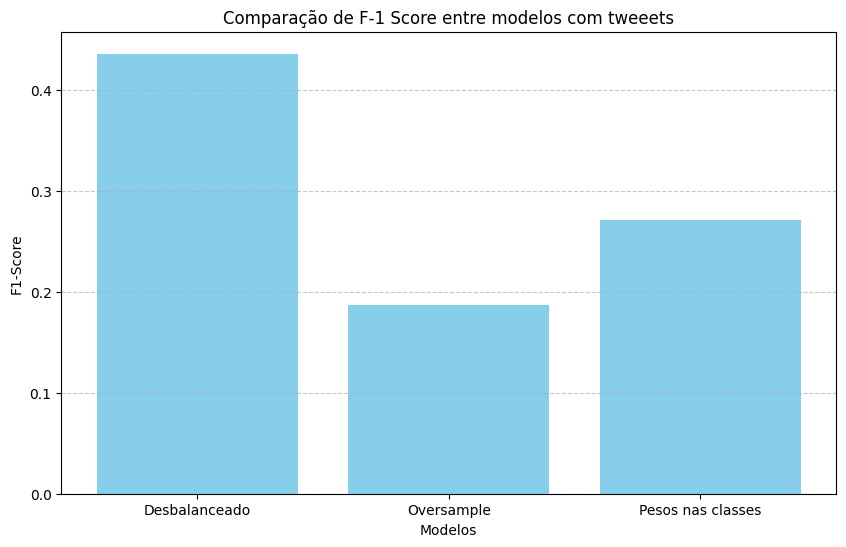

In [104]:
plot_f1_score([unbalaced_model_t, oversampled_model_t, weighted_model_t], ["Desbalanceado", "Oversample", "Pesos nas classes"], test_dataloader_with_tweets, "Comparação de F-1 Score entre modelos com tweeets")

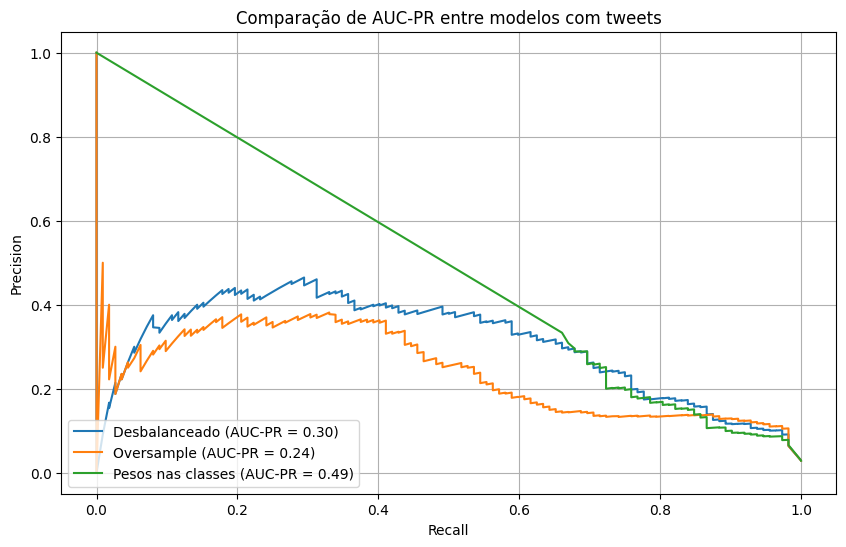

In [105]:
plot_auc_pr([unbalaced_model_t, oversampled_model_t, weighted_model_t], ["Desbalanceado", "Oversample", "Pesos nas classes"], test_dataloader_with_tweets, "Comparação de AUC-PR entre modelos com tweets")

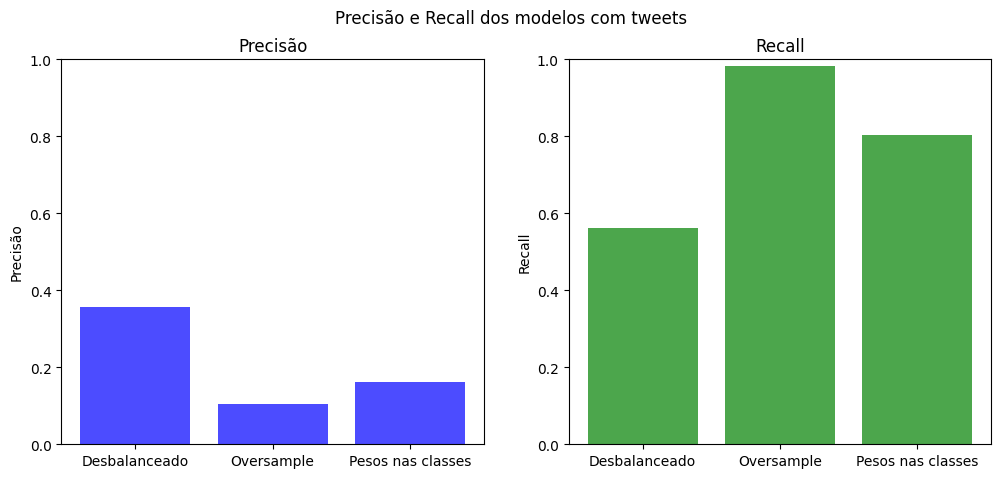

In [106]:
plot_precision_recall([unbalaced_model_t, oversampled_model_t, weighted_model_t], ["Desbalanceado", "Oversample", "Pesos nas classes"], test_dataloader_with_tweets, "Precisão e Recall dos modelos com tweets")